# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

((50000, 1, 28, 28), (50000,))


In [3]:
input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [4]:
import lasagne
from lasagne.layers import *

l = InputLayer(shape = input_shape,input_var=input_X)
l=Conv2DLayer(l,32,5)
l=MaxPool2DLayer(l,2)
l=DropoutLayer(l,0.5)
l = DenseLayer(l,num_units=100)
l=DropoutLayer(l,0.5)
l_out = DenseLayer(l,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(l_out)
y_predicted_test = lasagne.layers.get_output(l_out,deterministic=True)

In [6]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(l_out)
print all_weights

[W, b, W, b, W, b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [7]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()
accuracy_test = lasagne.objectives.categorical_accuracy(y_predicted_test,target_y).mean()


#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.1)

In [8]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy_test)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [9]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

In [10]:
import time

num_epochs = 150 #amount of passes through the data

batch_size = 200 #number of samples processed at each function call

loss_hist=[]

start_time = time.time()
max_accur=0
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {}, {:.3f}min".format(
        epoch + 1, num_epochs, (time.time() - start_time)/60))
    
    loss_hist.append(train_err / train_batches)
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))
    if val_acc>max_accur:
        max_accur=val_acc
        print("-------------------------------------------------------------Curent Max")

Epoch 1 of 150, 0.613min
  training loss (in-iteration):		0.701184
  train accuracy:		77.45 %
  validation accuracy:		94.29 %
-------------------------------------------------------------Curent Max
Epoch 2 of 150, 1.225min
  training loss (in-iteration):		0.311407
  train accuracy:		90.58 %
  validation accuracy:		96.19 %
-------------------------------------------------------------Curent Max
Epoch 3 of 150, 1.837min
  training loss (in-iteration):		0.233136
  train accuracy:		93.13 %
  validation accuracy:		97.12 %
-------------------------------------------------------------Curent Max
Epoch 4 of 150, 2.449min
  training loss (in-iteration):		0.194031
  train accuracy:		94.24 %
  validation accuracy:		97.46 %
-------------------------------------------------------------Curent Max
Epoch 5 of 150, 3.081min
  training loss (in-iteration):		0.165891
  train accuracy:		95.04 %
  validation accuracy:		97.85 %
-------------------------------------------------------------Curent Max
Epoch 6 of

Epoch 52 of 150, 32.339min
  training loss (in-iteration):		0.045247
  train accuracy:		98.52 %
  validation accuracy:		98.97 %
Epoch 53 of 150, 32.959min
  training loss (in-iteration):		0.045307
  train accuracy:		98.57 %
  validation accuracy:		99.04 %
Epoch 54 of 150, 33.577min
  training loss (in-iteration):		0.045091
  train accuracy:		98.56 %
  validation accuracy:		99.05 %
Epoch 55 of 150, 34.194min
  training loss (in-iteration):		0.043378
  train accuracy:		98.65 %
  validation accuracy:		98.98 %
Epoch 56 of 150, 34.819min
  training loss (in-iteration):		0.044104
  train accuracy:		98.57 %
  validation accuracy:		98.97 %
Epoch 57 of 150, 35.443min
  training loss (in-iteration):		0.043728
  train accuracy:		98.59 %
  validation accuracy:		99.02 %
Epoch 58 of 150, 36.067min
  training loss (in-iteration):		0.044171
  train accuracy:		98.58 %
  validation accuracy:		99.02 %
Epoch 59 of 150, 36.693min
  training loss (in-iteration):		0.041362
  train accuracy:		98.64 %
  valida

Epoch 115 of 150, 71.646min
  training loss (in-iteration):		0.029404
  train accuracy:		99.00 %
  validation accuracy:		99.13 %
-------------------------------------------------------------Curent Max
Epoch 116 of 150, 72.259min
  training loss (in-iteration):		0.028881
  train accuracy:		99.02 %
  validation accuracy:		99.08 %
Epoch 117 of 150, 72.875min
  training loss (in-iteration):		0.030024
  train accuracy:		98.95 %
  validation accuracy:		99.06 %
Epoch 118 of 150, 73.488min
  training loss (in-iteration):		0.030034
  train accuracy:		99.00 %
  validation accuracy:		99.09 %
Epoch 119 of 150, 74.102min
  training loss (in-iteration):		0.028734
  train accuracy:		99.04 %
  validation accuracy:		99.11 %
Epoch 120 of 150, 74.717min
  training loss (in-iteration):		0.027704
  train accuracy:		99.06 %
  validation accuracy:		99.10 %
Epoch 121 of 150, 75.331min
  training loss (in-iteration):		0.027533
  train accuracy:		99.10 %
  validation accuracy:		99.07 %
Epoch 122 of 150, 75.947m

In [11]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
  test accuracy:		99.20 %
Achievement unlocked: 80lvl Warlock!


# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!

# Report

I used the follow NN:

1. Conv(32,5)
2. MaxPool(2)
5. Dropout(0.5)
6. Dense(100)
7. Dropout(0.5)
8. Dense(10)

As we can see, the stable 99% accuracy on validation we get on 55 min.

Device parameters: i7-4770 CPU, 3.40×8, 16 RAM

#### I've learned the following:

1. Dropout laters prevent overfiting. But one should don't forget to remove Dropouts by "deterministic=True" when test NN
2. MaxPool not only save our time but also affect to accuracy. As I understand, after MaxPool, the area which goes to Conv filter becоmes more informative. But one should don't increase pooling level much to avoid information loosing.
3. Linear is faster than other nonlinearities but nonlinearities better guarantee the convergance.

Below you see the history of Loss Function.

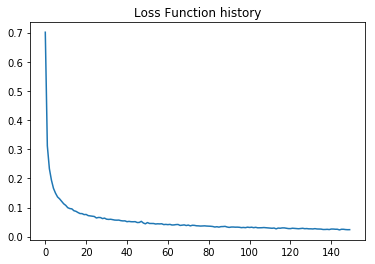

In [12]:
plt.plot(range(num_epochs), loss_hist)
plt.title("Loss Function history")
plt.show()